In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigData_Final_Project_IPYNB") \
    .getOrCreate()

sc = spark.sparkContext
print("Spark started.")


25/12/25 20:51:40 WARN Utils: Your hostname, spark resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/25 20:51:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/25 20:51:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark started.


In [2]:
MOVIES_PATH = "file:///home/spark/Desktop/ProjeData/ml-latest-small/movies.csv"
RATINGS_PATH = "file:///home/spark/Desktop/ProjeData/ml-latest-small/ratings.csv"

print(MOVIES_PATH)
print(RATINGS_PATH)


file:///home/spark/Desktop/ProjeData/ml-latest-small/movies.csv
file:///home/spark/Desktop/ProjeData/ml-latest-small/ratings.csv


In [3]:
movies_rdd = sc.textFile(MOVIES_PATH)
header = movies_rdd.first()
movies_data = movies_rdd.filter(lambda x: x != header)

def genre_mapper(line):
    parts = line.split(",")
    return parts[-1].split("|")

genre_counts = (
    movies_data
    .map(genre_mapper)
    .flatMap(lambda x: x)
    .map(lambda g: (g, 1))
    .reduceByKey(lambda a, b: a + b)
    .sortBy(lambda x: x[1], ascending=False)
)

result_genres = genre_counts.collect()
result_genres[:10]


[('Drama', 4361),
 ('Comedy', 3756),
 ('Thriller', 1894),
 ('Action', 1828),
 ('Romance', 1596),
 ('Adventure', 1263),
 ('Crime', 1199),
 ('Sci-Fi', 980),
 ('Horror', 978),
 ('Fantasy', 779)]

In [4]:
print("=== MAPREDUCE RESULT: MOVIES PER GENRE ===")
for g, c in result_genres:
    if g:
        print(f"{g:<15} : {c}")


=== MAPREDUCE RESULT: MOVIES PER GENRE ===
Drama           : 4361
Comedy          : 3756
Thriller        : 1894
Action          : 1828
Romance         : 1596
Adventure       : 1263
Crime           : 1199
Sci-Fi          : 980
Horror          : 978
Fantasy         : 779
Children        : 664
Animation       : 611
Mystery         : 573
Documentary     : 440
War             : 382
Musical         : 334
Western         : 167
IMAX            : 158
Film-Noir       : 87
(no genres listed) : 34


In [5]:
movies_df = spark.read.csv(MOVIES_PATH, header=True, inferSchema=True)
ratings_df = spark.read.csv(RATINGS_PATH, header=True, inferSchema=True)

print("movies_df rows:", movies_df.count())
print("ratings_df rows:", ratings_df.count())


movies_df rows: 9742
ratings_df rows: 100836


In [6]:
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
print("Temp views created.")


Temp views created.


In [7]:
query1 = """
SELECT
    m.title AS Movie_Title,
    ROUND(AVG(r.rating), 2) AS Avg_Rating,
    COUNT(r.rating) AS Rating_Count
FROM movies m
JOIN ratings r ON m.movieId = r.movieId
GROUP BY m.title
HAVING COUNT(r.rating) > 100
ORDER BY Avg_Rating DESC, Rating_Count DESC
LIMIT 10
"""

q1_df = spark.sql(query1)
q1_df.show(truncate=False)


+-----------------------------------------+----------+------------+
|Movie_Title                              |Avg_Rating|Rating_Count|
+-----------------------------------------+----------+------------+
|Shawshank Redemption, The (1994)         |4.43      |317         |
|Godfather, The (1972)                    |4.29      |192         |
|Fight Club (1999)                        |4.27      |218         |
|Godfather: Part II, The (1974)           |4.26      |129         |
|Goodfellas (1990)                        |4.25      |126         |
|Departed, The (2006)                     |4.25      |107         |
|Usual Suspects, The (1995)               |4.24      |204         |
|Dark Knight, The (2008)                  |4.24      |149         |
|Star Wars: Episode IV - A New Hope (1977)|4.23      |251         |
|Schindler's List (1993)                  |4.23      |220         |
+-----------------------------------------+----------+------------+



In [8]:
from pyspark.sql.functions import split, explode, col

movies_exploded = movies_df.withColumn("genre", explode(split(col("genres"), "\\|")))
movies_exploded.createOrReplaceTempView("movies_exploded")

query2 = """
SELECT
    m.genre AS Genre,
    ROUND(AVG(r.rating), 2) AS Avg_Rating,
    COUNT(*) AS Total_Ratings
FROM movies_exploded m
JOIN ratings r ON m.movieId = r.movieId
GROUP BY m.genre
ORDER BY Avg_Rating DESC
"""

q2_df = spark.sql(query2)
q2_df.show(30, truncate=False)


+------------------+----------+-------------+
|Genre             |Avg_Rating|Total_Ratings|
+------------------+----------+-------------+
|Film-Noir         |3.92      |870          |
|War               |3.81      |4859         |
|Documentary       |3.8       |1219         |
|Crime             |3.66      |16681        |
|Drama             |3.66      |41928        |
|Mystery           |3.63      |7674         |
|Animation         |3.63      |6988         |
|IMAX              |3.62      |4145         |
|Western           |3.58      |1930         |
|Musical           |3.56      |4138         |
|Romance           |3.51      |18124        |
|Adventure         |3.51      |24161        |
|Thriller          |3.49      |26452        |
|Fantasy           |3.49      |11834        |
|(no genres listed)|3.49      |47           |
|Sci-Fi            |3.46      |17243        |
|Action            |3.45      |30635        |
|Children          |3.41      |9208         |
|Comedy            |3.38      |390

In [9]:
from pyspark.sql.functions import avg, count, when

movie_features = ratings_df.groupBy("movieId").agg(
    count("rating").alias("rating_count"),
    avg("rating").alias("avg_rating")
)

movie_features = movie_features.withColumn(
    "popular",
    when(col("rating_count") > 100, 1).otherwise(0)
)

movie_features.show(5)


+-------+------------+-----------------+-------+
|movieId|rating_count|       avg_rating|popular|
+-------+------------+-----------------+-------+
|   1580|         165|3.487878787878788|      1|
|   2366|          25|             3.64|      0|
|   3175|          75|             3.58|      0|
|   1088|          42|3.369047619047619|      0|
|  32460|           4|             4.25|      0|
+-------+------------+-----------------+-------+
only showing top 5 rows



In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

assembler_cls = VectorAssembler(
    inputCols=["rating_count", "avg_rating"],
    outputCol="features"
)

cls_data = assembler_cls.transform(movie_features).select("features", "popular", "rating_count", "avg_rating")

train_cls, test_cls = cls_data.randomSplit([0.8, 0.2], seed=42)

lr_cls = LogisticRegression(labelCol="popular")
cls_model = lr_cls.fit(train_cls)

predictions_cls = cls_model.transform(test_cls)

evaluator_cls = MulticlassClassificationEvaluator(
    labelCol="popular",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator_cls.evaluate(predictions_cls)
accuracy


1.0

In [11]:
import os
import matplotlib.pyplot as plt

os.makedirs("plots", exist_ok=True)

pdf_cls = cls_data.select("rating_count", "avg_rating", "popular").sample(0.15, seed=42).toPandas()

plt.figure(figsize=(7,5))
plt.scatter(pdf_cls["rating_count"], pdf_cls["avg_rating"], c=pdf_cls["popular"], alpha=0.6)
plt.xlabel("Rating Count")
plt.ylabel("Average Rating")
plt.title("Classification: Popular vs Non-Popular")
plt.savefig("plots/classification_plot.png")
plt.close()

print("Saved: plots/classification_plot.png")


Saved: plots/classification_plot.png


In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Feature engineering
movie_features = ratings_df.groupBy("movieId").agg(
    count("rating").alias("rating_count"),
    avg("rating").alias("avg_rating")
)

assembler_reg = VectorAssembler(
    inputCols=["rating_count"],
    outputCol="features"
)

reg_data = assembler_reg.transform(movie_features) \
    .select("features", "rating_count", "avg_rating")

train_reg, test_reg = reg_data.randomSplit([0.8, 0.2], seed=42)

lr_reg = LinearRegression(labelCol="avg_rating")
reg_model = lr_reg.fit(train_reg)

predictions_reg = reg_model.transform(test_reg)

evaluator = RegressionEvaluator(
    labelCol="avg_rating",
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions_reg)
print("RMSE:", rmse)


25/12/25 20:56:00 WARN Instrumentation: [01998a2a] regParam is zero, which might cause numerical instability and overfitting.


RMSE: 0.8498943042184193


In [14]:
import numpy as np
import matplotlib.pyplot as plt

pdf_reg = predictions_reg.select(
    "rating_count", "avg_rating", "prediction"
).sample(0.15, seed=42).toPandas()

pdf_reg = pdf_reg.sort_values("rating_count")

plt.figure(figsize=(7,5))
plt.scatter(pdf_reg["rating_count"], pdf_reg["avg_rating"], alpha=0.5)
plt.plot(pdf_reg["rating_count"], pdf_reg["prediction"], color="red")
plt.xlabel("Rating Count")
plt.ylabel("Average Rating")
plt.title("Regression: Vote Count vs Average Rating")
plt.savefig("plots/regression_plot.png")
plt.close()

print("Saved: plots/regression_plot.png")


Saved: plots/regression_plot.png


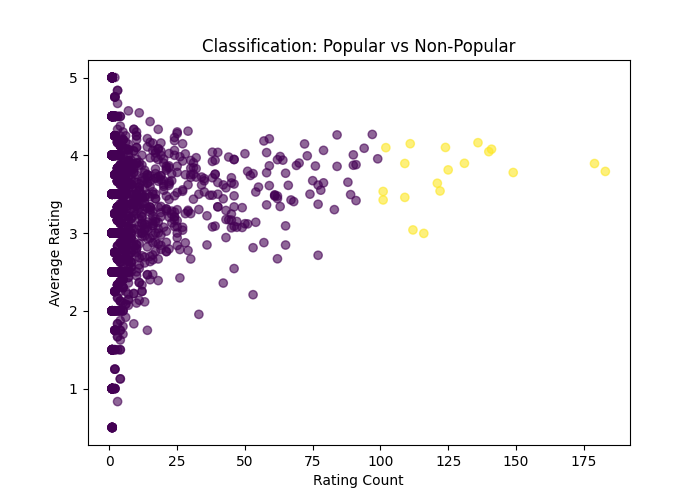

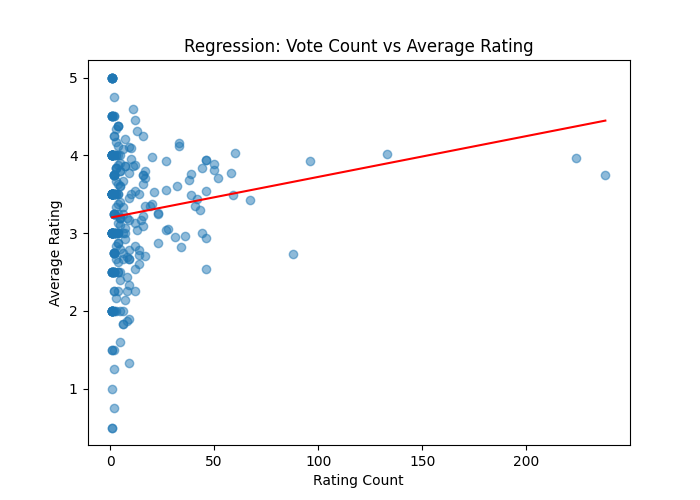

In [15]:
from IPython.display import Image, display

display(Image("plots/classification_plot.png"))
display(Image("plots/regression_plot.png"))
